In [2]:
#Librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

In [6]:
#Hagamos regresion logística con el data set FINAL

#Levantamos el df_final_alternativo_2
data = pd.read_csv('PVR_train_test.csv')

#Generamos el X y el target
X= data.drop(['Target_NoApto'], axis = 1)
y= data['Target_NoApto']

#Divimos en train y en test
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, test_size= 0.25)

#Estandarizamos con MinMax
scaler = MinMaxScaler()

X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.fit_transform(X_test)

In [7]:
# Buscamos los mejores hiperparametros

modelo = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

# Defnimos una grilla con GridSearch

grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=20, n_repeats=3, random_state=999)
grid_search = GridSearchCV(estimator=modelo, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)

# Vemos los resultados

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.754211 using {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.737545 (0.067766) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.741416 (0.068847) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.737007 (0.067857) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.738100 (0.067042) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.737563 (0.066844) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.736452 (0.068172) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.741398 (0.064951) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.743638 (0.063376) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.744211 (0.062088) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.746953 (0.054422) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.754211 (0.051691) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.739857 (0.055373) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.717061 (0.053081) with: {

C:\Users\DataScience\anaconda3\envs\dhdsblend2021\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [14]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Oranges',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [9]:
#Instanciamos el modelo y los ajustamos a los datos de entrenamiento
modelo = LogisticRegression(C=0.1, penalty = 'l2', solver= 'lbfgs')
modelo.fit(X_train_std, y_train)

LogisticRegression(C=0.1)

In [10]:
#Para UN solo fold
#Hacemos las predicciones necesarias
y_pred = modelo.predict(X_test_std)
print(y_pred)
#Evaluamos el score
print('')
print('Score: ', accuracy_score(y_test, y_pred))

[1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1]

Score:  0.7326732673267327


In [11]:
#Generalizamos para 20 folds
stratifiedkf=StratifiedKFold(n_splits=10)
score=cross_val_score(modelo,X_train,y_train,cv=stratifiedkf)
print("Los scores obtenidos son {}".format(score))
print("El promedio es :{}".format(score.mean()))

C:\Users\DataScience\anaconda3\envs\dhdsblend2021\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\DataScience\anaconda3\envs\dhdsblend2021\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

Los scores obtenidos son [0.86885246 0.70491803 0.72131148 0.76666667 0.73333333 0.73333333
 0.75       0.75       0.75       0.73333333]
El promedio es :0.7511748633879781


C:\Users\DataScience\anaconda3\envs\dhdsblend2021\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\DataScience\anaconda3\envs\dhdsblend2021\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

In [12]:
cf_matrix_a = confusion_matrix(y_pred,y_test)

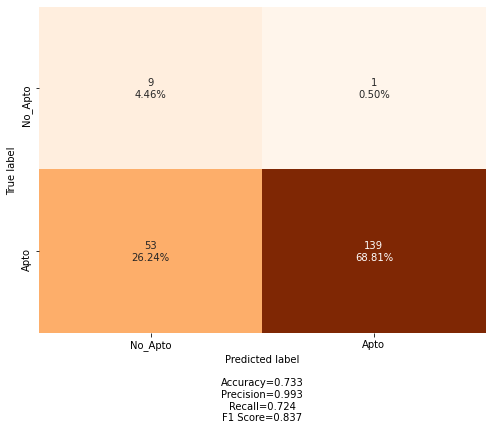

In [15]:
make_confusion_matrix(cf_matrix_a, categories= ['No_Apto', 'Apto'] , figsize=(8,6), cbar=False)

In [16]:
y_pred_proba = modelo.predict_proba(X_test_std)

In [17]:
display(y_pred_proba.shape, y_pred_proba)

(202, 2)

array([[0.09870756, 0.90129244],
       [0.29619321, 0.70380679],
       [0.31224336, 0.68775664],
       [0.36204678, 0.63795322],
       [0.14907911, 0.85092089],
       [0.38125675, 0.61874325],
       [0.39787066, 0.60212934],
       [0.17371151, 0.82628849],
       [0.31224336, 0.68775664],
       [0.17904298, 0.82095702],
       [0.09323656, 0.90676344],
       [0.22725985, 0.77274015],
       [0.32715407, 0.67284593],
       [0.50802043, 0.49197957],
       [0.31364216, 0.68635784],
       [0.16740701, 0.83259299],
       [0.36759018, 0.63240982],
       [0.09091551, 0.90908449],
       [0.56915428, 0.43084572],
       [0.40030167, 0.59969833],
       [0.40030167, 0.59969833],
       [0.41492416, 0.58507584],
       [0.3027533 , 0.6972467 ],
       [0.26368545, 0.73631455],
       [0.25389857, 0.74610143],
       [0.20637192, 0.79362808],
       [0.38769665, 0.61230335],
       [0.17904298, 0.82095702],
       [0.25389857, 0.74610143],
       [0.20107776, 0.79892224],
       [0.

In [55]:
# Nos quedamos con la columna que tiene la probabilidad positiva de cada caso
y_probs_logit_left = y_pred_proba[:,1]

#Cambiamos el umbral
ya_pred_logit = (y_probs_logit_left > 0.25).astype(int)
cf_matrix_a_logit = confusion_matrix(ya_pred_logit,ya_test)

In [56]:
print('Matrix Original')
display(confusion_matrix(ya_pred,ya_test))
print('')
print('Nueva Matrix')
display(confusion_matrix(ya_pred_logit,ya_test))

Matrix Original


array([[136,  35],
       [  8,  26]], dtype=int64)


Nueva Matrix


array([[95, 15],
       [49, 46]], dtype=int64)

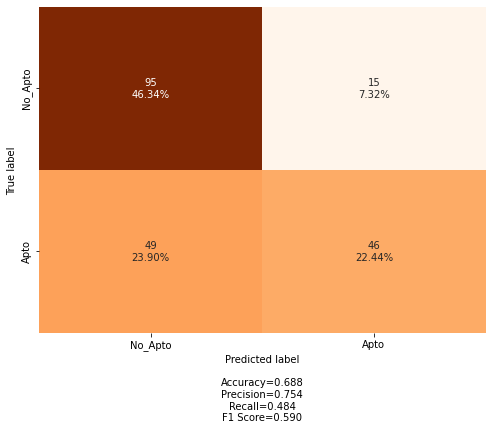

In [57]:
make_confusion_matrix(cf_matrix_a_logit, categories= ['No_Apto','Apto'] , figsize=(8,6), cbar=False)

In [46]:
from sklearn.metrics import roc_curve
fpr_log,tpr_log,thr_log = roc_curve(ya_test, y_pred_proba[:,1])

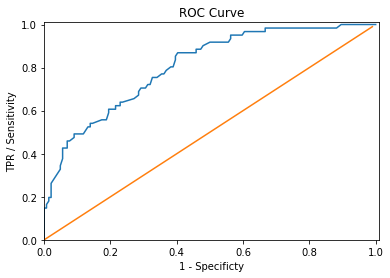

In [47]:
df = pd.DataFrame(dict(fpr=fpr_log, tpr=tpr_log, thr = thr_log))

plt.axis([0, 1.01, 0, 1.01])
plt.xlabel('1 - Specificty')
plt.ylabel('TPR / Sensitivity')
plt.title('ROC Curve')
plt.plot(df['fpr'],df['tpr'])
plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))
plt.show()

In [48]:
from sklearn.metrics import auc
print('AUC=', auc(fpr_log, tpr_log))

AUC= 0.8052140255009107
